# Demo of generating csv for test-set
We hope this jupyter notebook is helpful in understanding how to generate the csv file to be uploaded to EvalAI or benchmarking.

**Author**: `Shu Kong <shuk@andrew.cmu.edu>`

**Date**: May 2020

import packages
------------------

Some packages are installed automatically through Anaconda. PyTorch should be also installed.

In [1]:
from __future__ import print_function, division
import random, time, copy, scipy, pickle, sys, math, gzip, html, os, ftfy, torch, json
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc, ndimage, signal
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

from functools import lru_cache
import pandas as pd
import seaborn as sn
import sklearn.metrics 
import regex as re

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.dataset_OWV import *
from utils.network_arch import *
from utils.trainval import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")


print(sys.version)
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
1.7.1
True
9.2


## Setup config parameters
  
There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
# set the random seed
torch.manual_seed(0)

# experiment directory, used for reading the init model
exp_dir = './exp' 

project_name = 'dummy_model'

# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'

nClassTotal = 414
isPretrained = False
encoder_num_layers = 18

batch_size = 64
total_epoch_num = 90 # total number of epoch in training
base_lr = 0.001 # base learning rate

torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')


clsModel = ResnetEncoder(encoder_num_layers, isPretrained, embDimension=nClassTotal, poolSize=7)

./exp/dummy_model


In [3]:
################## load model ###################
path_to_classifier = os.path.join(save_dir, 'model_for_demo.paramOnly')
clsModel.load_state_dict(torch.load(path_to_classifier));
clsModel.cuda();
clsModel.to(device);
clsModel.eval();

## get testing images

In [4]:
path_to_data = '/compute/trinity-0-12/shuk/dataset/dataset-open-world-vision-challenge'

imageList = []
labelList = []

curvalID = './labels_valsets/testset_namelist.csv'
file_pred = curvalID.replace('.csv', '_pred.csv')

with open(path.join(curvalID)) as fn:
    for line in fn:
        tmp = line.strip().split(',')
        curname = tmp[0]
        imageList.append(path.join('/scratch/shuk/dataset/testset_owv/images',curname))
labelList = [-1] * len(imageList)
print(len(imageList), len(labelList))

50000 50000


In [5]:
set_name = 'test'
datasets = {}
dataloaders = {}
datasets[set_name] = OWV_dataset(set_name=set_name, imageList=imageList, labelList=labelList, isAugment=False)
print(len(datasets[set_name]))


batch_size = 48

dataloaders[set_name] = DataLoader(
    datasets[set_name],
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4) # num_work can be set to batch_size

print(len(dataloaders['test']))

50000
1042


torch.Size([48, 3, 224, 224])


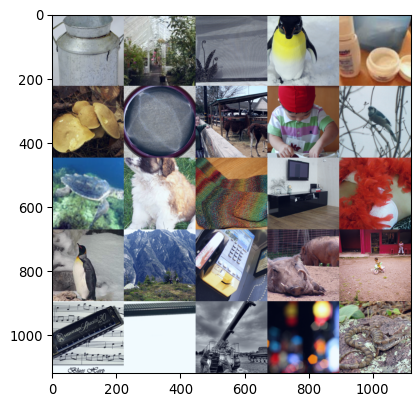

In [6]:
data_sampler = iter(dataloaders['test'])
data = next(data_sampler)
imageList224, labelList = data

imageList224 = imageList224.to(device)
labelList = labelList.type(torch.long).view(-1).to(device)

print(imageList224.shape)

imList = imageList224.permute(0,2,3,1).cpu().numpy()
imList -= imList.min()
imList /= imList.max()+0.0001
imList = createMontage(imList, (224, 224, 25))

fig = plt.figure(figsize=(5,5), dpi=95) # better display with larger figure
plt.imshow(imList)

# run the model over testing images

In [7]:
predScores = []
predList = np.array([])
for sample in dataloaders['test']:
    images, labels = sample
    images = images.to(device)
    labels = labels.type(torch.long).view(-1).numpy()
    with torch.no_grad(): 
        logits = clsModel(images).detach().squeeze()
        softmaxScores = F.softmax(logits, dim=1)
        
        # this is an engineering effort to tweak the likelihood of unknown detection, 
        # cf. Max of Softmax Probability in this paper: 
        # A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks
        # https://arxiv.org/abs/1610.02136
        softmaxScores[:,0] = (1-softmaxScores[:,1:].max(dim=1)[0])*0.5
        
        predLabels = softmaxScores.argmax(dim=1).cpu().numpy()
        predList = np.concatenate((predList, predLabels))    
        predScores.append(softmaxScores.detach().cpu().numpy())
    
predScores = np.concatenate(predScores, axis=0)

# save the results using the following templates

In [8]:
file_pred = 'results/testset_pred.csv'
fn_pred = open(file_pred, 'w')

# save the results in the prediction file, which is the user uploaded file.
for i, curimagename in enumerate(imageList):
    tmp = curimagename.split('/')
    fn_pred.write('{}'.format(tmp[-1]))
    for j in range(nClassTotal):
        fn_pred.write(',{:.3f}'.format(predScores[i][j]))
    fn_pred.write('\n')

fn_pred.close()